# 任务2 数据清洗(2天)

In [41]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

# GBDT
from sklearn.ensemble import GradientBoostingRegressor
# XGBoost
import xgboost as xgb
# LightGBM
import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import pickle
import multiprocessing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression,LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [42]:
#载入数据
data_train = pd.read_csv('./train_data.csv')
data_train['Type'] = 'Train'
data_test = pd.read_csv('./test_a.csv')
data_test['Type'] = 'Test'
data_all = pd.concat([data_train, data_test], ignore_index=True)
fea_cols = [col for col in data_train.columns]

# 异常值处理

In [43]:
data_train.head(5)
print(fea_cols)

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0,Train
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0,Train
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0,Train
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0,Train
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0,Train


['ID', 'area', 'rentType', 'houseType', 'houseFloor', 'totalFloor', 'houseToward', 'houseDecoration', 'communityName', 'city', 'region', 'plate', 'buildYear', 'saleSecHouseNum', 'subwayStationNum', 'busStationNum', 'interSchoolNum', 'schoolNum', 'privateSchoolNum', 'hospitalNum', 'drugStoreNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum', 'superMarketNum', 'totalTradeMoney', 'totalTradeArea', 'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney', 'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum', 'supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum', 'tradeLandArea', 'landTotalPrice', 'landMeanPrice', 'totalWorkers', 'newWorkers', 'residentPopulation', 'pv', 'uv', 'lookNum', 'tradeTime', 'tradeMoney', 'Type']


**该数据集房屋面积特征有明显异常值**

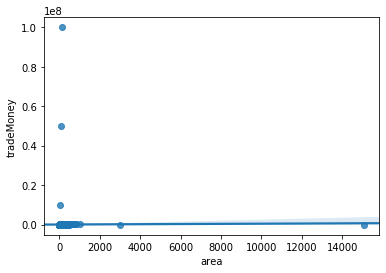

In [44]:
sns.regplot(x=data_train['area'],y=data_train['tradeMoney'])

**孤立森林：基于Ensemble的快速异常检测方法**

In [45]:
# clean data
def IF_drop(train):
    IForest = IsolationForest(contamination=0.01)
    IForest.fit(train["tradeMoney"].values.reshape(-1,1))
    y_pred = IForest.predict(train["tradeMoney"].values.reshape(-1,1))
    drop_index = train.loc[y_pred==-1].index
    print(len(drop_index))
    print(drop_index)
    train.drop(drop_index,inplace=True)
    return train

data_train = IF_drop(data_train)
# data_train.head(5)

401
Int64Index([   62,    69,   128,   131,   246,   261,   266,   297,   308,
              313,
            ...
            39224, 39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083,
            41233],
           dtype='int64', length=401)


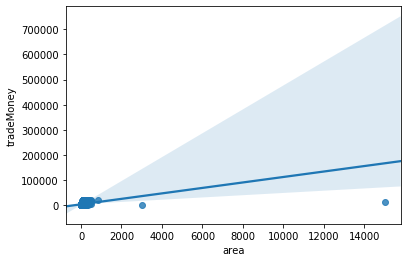

len(data_train): 40215


In [46]:
def dropData(train):
    # 丢弃部分异常值
    train = train[train.area <= 200]
    train = train[(train.tradeMoney <=16000) & (train.tradeMoney >=700)]
    train.drop(train[(train['totalFloor'] == 0)].index, inplace=True)
    sns.regplot(x=data_train['area'],y=data_train['tradeMoney'])
    plt.show()
    return train  
#数据集异常值处理
data_train = dropData(data_train)
print('len(data_train):', len(data_train))

<Figure size 1080x360 with 0 Axes>

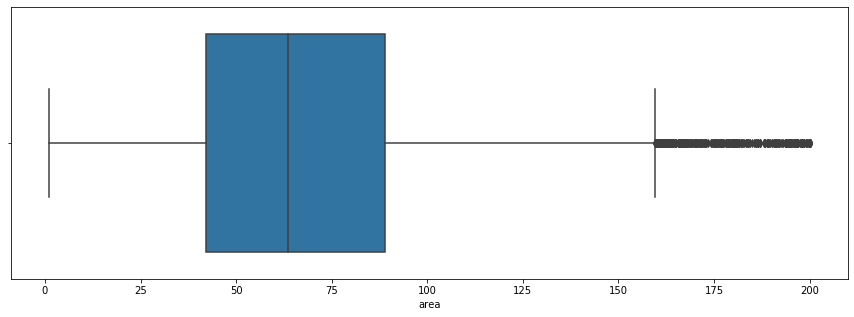

<Figure size 1080x360 with 0 Axes>

(<matplotlib.axes._subplots.AxesSubplot at 0x7f884e5dff60>,)

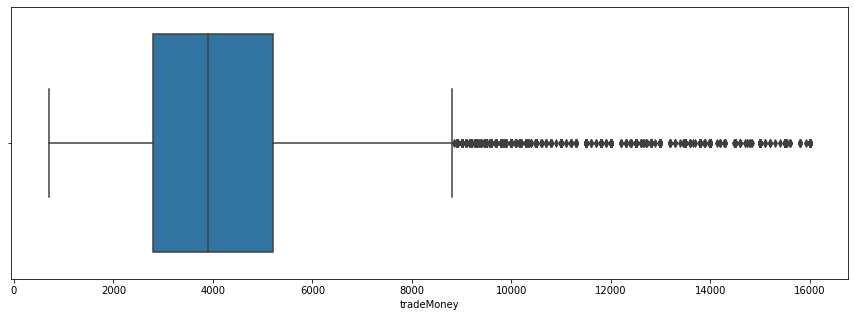

In [47]:
# 处理异常值后再次查看面积和租金分布图
plt.figure(figsize=(15,5))
sns.boxplot(data_train.area)
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data_train.tradeMoney),
plt.show()

# 缺失值处理、数据变换

**缺失值的处理方式：**<br>
- 删除带有缺失值的特征，最简单也最浪费信息的方式<br>
- 用均值，众数或固定的数等填充，比1好，但仍不够好<br>
- 考虑缺失的含义，把缺失值作为一种信息<br>
- 用未缺失的数据训练模型，预测缺失的数据（分类型变量用分类算法，数值型变量用回归）<br>
（tip：把训练集和测试集合并处理，减少代码量）


In [48]:
data_train.head(5)

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0,Train
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0,Train
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0,Train
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0,Train
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0,Train


In [49]:
def preprocessingData(data):
    # 填充缺失值
    data['rentType'][data['rentType'] == '--'] = '未知方式'
    
    # 转换object类型数据
    columns = ['rentType', 'houseType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'plate']
    for feature in columns:
        data[feature] = LabelEncoder().fit_transform(data[feature])

    # 将buildYear列转换为整型数据
    buildYearmean = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
    data.loc[data[data['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearmean.iloc[0, 0]
    data['buildYear'] = data['buildYear'].astype('int')

    # 处理pv和uv的空值填充为平均值
    data['pv'].fillna(data['pv'].mean(), inplace=True)
    data['uv'].fillna(data['uv'].mean(), inplace=True)
    data['pv'] = data['pv'].astype('int')
    data['uv'] = data['uv'].astype('int')

    # 分割交易时间
    def month(x):
        month = int(x.split('/')[1])
        return month
    def day(x):
        day = int(x.split('/')[2])
        return day
    data['month'] = data['tradeTime'].apply(lambda x: month(x))
    data['day'] = data['tradeTime'].apply(lambda x: day(x))
    
    # 去掉部分特征：city=SH, ID唯一, 
    data.drop('city', axis=1, inplace=True)
    data.drop('tradeTime', axis=1, inplace=True)
    data.drop('ID', axis=1, inplace=True)
    
    return data

data_train = preprocessingData(data_train)
data_train

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,2,11,1,16,6,0,50,RG00001,63,...,28248,614,111546,1124,284,0,2000.0,Train,11,28
1,125.55,2,26,0,14,6,2,124,RG00002,48,...,14823,148,157552,701,22,1,2000.0,Train,12,16
2,132.00,2,26,1,32,6,0,171,RG00002,49,...,77645,520,131744,57,20,1,16000.0,Train,12,22
3,57.00,2,3,0,17,6,3,300,RG00002,50,...,8750,1665,253337,888,279,9,1600.0,Train,12,21
4,129.00,2,27,1,2,6,1,1201,RG00003,43,...,800,117,125309,2038,480,0,2900.0,Train,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41435,10.00,0,36,2,11,3,3,1160,RG00002,61,...,20904,0,245872,29635,2662,0,2190.0,Train,2,5
41436,7.10,0,22,0,6,3,3,823,RG00002,54,...,4370,0,306857,28213,2446,0,2090.0,Train,1,22
41437,9.20,0,36,2,18,3,3,822,RG00002,54,...,4370,0,306857,19231,2016,0,3190.0,Train,2,8
41438,14.10,0,36,1,8,3,3,762,RG00002,54,...,4370,0,306857,17471,2554,0,2460.0,Train,3,22


# 深度清洗

In [50]:
data_train[data_train['region']=='RG00001']

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,2,11,1,16,6,0,50,RG00001,63,...,28248,614,111546,1124,284,0,2000.0,Train,11,28
94,56.58,2,11,2,6,6,0,9,RG00001,63,...,28248,0,111546,9502,1229,0,5400.0,Train,5,9
150,73.68,1,11,1,18,6,3,11,RG00001,63,...,28248,0,111546,9502,1229,0,7800.0,Train,5,22
200,102.00,2,11,2,7,6,0,12,RG00001,63,...,28248,0,111546,5076,604,0,4400.0,Train,3,11
371,78.00,2,14,1,7,6,0,35,RG00001,63,...,28248,0,111546,5076,604,0,2300.0,Train,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40659,29.50,2,1,0,6,3,0,85,RG00001,64,...,38947,0,157682,8799,2672,0,2950.0,Train,9,26
40766,6.70,0,22,2,6,3,3,95,RG00001,64,...,38947,0,157682,15022,1389,0,2560.0,Train,1,10
40787,29.40,2,3,2,6,3,0,86,RG00001,64,...,38947,0,157682,13461,1936,0,2600.0,Train,7,3
40788,29.50,2,1,2,6,3,0,85,RG00001,64,...,38947,0,157682,10958,1602,0,3500.0,Train,8,28


In [51]:
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    data['region'] = LabelEncoder().fit_transform(data['region'])
    return data

data_train = cleanData(data_train)

data_train

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,2,11,1,16,6,0,50,0,63,...,28248,614,111546,1124,284,0,2000.0,Train,11,28
1,125.55,2,26,0,14,6,2,124,1,48,...,14823,148,157552,701,22,1,2000.0,Train,12,16
2,132.00,2,26,1,32,6,0,171,1,49,...,77645,520,131744,57,20,1,16000.0,Train,12,22
3,57.00,2,3,0,17,6,3,300,1,50,...,8750,1665,253337,888,279,9,1600.0,Train,12,21
4,129.00,2,27,1,2,6,1,1201,2,43,...,800,117,125309,2038,480,0,2900.0,Train,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40130,10.00,0,36,2,11,3,3,1160,1,61,...,20904,0,245872,29635,2662,0,2190.0,Train,2,5
40131,7.10,0,22,0,6,3,3,823,1,54,...,4370,0,306857,28213,2446,0,2090.0,Train,1,22
40132,9.20,0,36,2,18,3,3,822,1,54,...,4370,0,306857,19231,2016,0,3190.0,Train,2,8
40133,14.10,0,36,1,8,3,3,762,1,54,...,4370,0,306857,17471,2554,0,2460.0,Train,3,22
